# Numerical Optimization

This notebook uses the [Optim](https://github.com/JuliaNLSolvers/Optim.jl) package which has routines for unconstrained optimization and for the case with simple bounds on the solution.

As alternatives, consider the [NLopt](https://github.com/JuliaOpt/NLopt.jl) or the [JuMP](https://github.com/JuliaOpt/JuMP.jl) packages. They can easily handle various types of constrained optimization problems.

## Load Packages and Extra Functions

In [1]:
using Printf, Optim

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :png)

# Optimization with One Choice Variable

Running 
```
Sol = optimize(x->fn1(x,0.5),x₀,x₁)
```
finds the `x` value (in the interval `[x₀,x₁]`) that *minimizes* `fn1(x,0.5)`. The solution for the `fn1` function below should be $x=1.1$. The `x->fn1(x,0.5)` syntax makes this a function of `x` only.

The output (`Sol`) contains a lot of information.

In [3]:
function fn1(x,c)                    #notice: the function has two arguments
  value = 2*(x - 1.1)^2 - c
  return value
end

fn1 (generic function with 1 method)

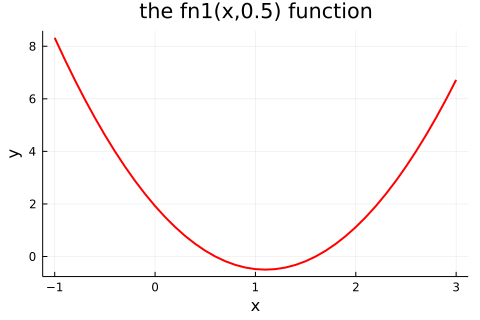

In [4]:
x = -1:0.1:3

p1 = plot( x,fn1.(x,0.5),
           linecolor = :red,
           linewidth = 2,
           legend = nothing,
           title = "the fn1(x,0.5) function",
           xlabel = "x",
           ylabel = "y" )
display(p1)

In [5]:
Sol = optimize(x->fn1(x,0.5),-2.0,3.0)
println(Sol)

printlnPs("\nThe minimum is at: ", Optim.minimizer(Sol))     #the optimal x value
println("Compare with the plot above\n")

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-2.000000, 3.000000]
 * Minimizer: 1.100000e+00
 * Minimum: -5.000000e-01
 * Iterations: 5
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 6

The minimum is at:      1.100
Compare with the plot above



## One Choice Variable: Supplying a Starting Guess Instead (extra)

If you prefer to give a starting guess `x₀` instead of an interval, then supply it as as a vector `[x₀]`:
```
Sol = optimize(x->fn1(x[],0.5),[x₀],LBFGS())  
```
Notice: *(a)* `x[]` to make it a function of the first (and only) element in the vector `x`; *(b)* choose the `LBFGS()` method since the default method does not work in the case of only one choice variable.

In [6]:
Solb = optimize(x->fn1(x[],0.5),[0.1],LBFGS())

printlnPs("The minimum is at: ", Optim.minimizer(Solb))

The minimum is at:      1.100


# Several Choice Variables: Unconstrained Optimization

In the example below, we choose $(x,y)$ so as to minimize the fairly simple objective function

$
(x-2)^2 + (4y+3)^2,  
$

without any constraints. The solution should be $(x,y)=(2,-3/4)$.

In [7]:
function fn2(p)
    (x,y) = (p[1],p[2])          #unpack the choice variables and get nicer names
     L    = (x-2)^2 + (4*y+3)^2
    return L
end

fn2 (generic function with 1 method)

In [8]:
nx = 2*41
ny = 2*61
x = range(1,5,length=nx)
y = range(-1,0,length=ny)

loss2d = fill(NaN,(nx,ny))      #matrix with loss fn values
for i = 1:nx, j = 1:ny
    loss2d[i,j] = fn2([x[i];y[j]])
end

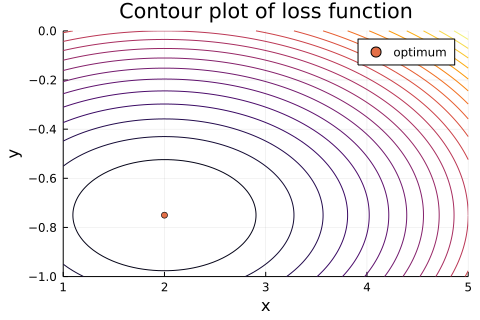

In [9]:
p1 = contour( x,y,loss2d',       #notice: loss2d'
              xlims = (1,5),
              ylims = (-1,0),
              legend = false,
              levels = 21,
              title = "Contour plot of loss function",
              xlabel = "x",
              ylabel = "y" )
scatter!([2],[-0.75],label="optimum",legend=true)
display(p1)

In [10]:
Sol = optimize(fn2,[0.0;0.0])        #use p->lossfn(p,other arguments) if 
                                     #there are additional (non-choice) arguments
printlnPs("minimum at (x,y)= ",Optim.minimizer(Sol))

minimum at (x,y)=      2.000    -0.750


# Several Choice Variables: Bounds on the Solutions

The next few cells discuss how to impose bounds on the solution.

In the example below, we impose $2.75 \leq x$ (a lower bound) and $y \leq -0.3$ (an upper bound). We will see that only one of these restrictions binds.

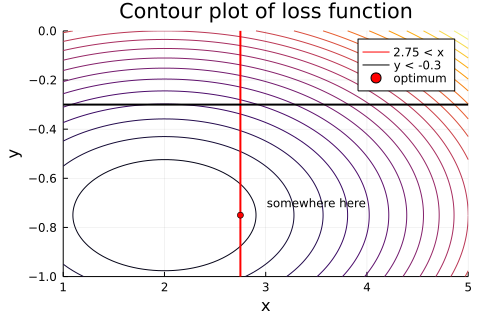

In [11]:
p1 = contour( x,y,loss2d',
              xlims = (1,5),
              ylims = (-1,0),
              legend = false,
              levels = 21,
              title = "Contour plot of loss function",
              xlabel = "x",
              ylabel = "y",
              annotation = (3.5,-0.7,text("somewhere here",8)) )
plot!([2.75,2.75],[-1,0.5],color=:red,linewidth=2,label="2.75 < x",legend = true)
plot!([1,5],[-0.3,-0.3],color=:black,linewidth=2,label="y < -0.3")
scatter!([2.75],[-0.75],color=:red,label="optimum")
display(p1)

In [12]:
lower = [2.75, -Inf]
upper = [Inf, -0.3]

Sol = optimize(fn2,lower,upper,[3.0,-0.5])
printlnPs("The optimum is at (x,y) = ",Optim.minimizer(Sol))

The optimum is at (x,y) =      2.750    -0.750


# Several Choice Variables:  Supplying the Gradient (extra)

Supplying a function for calculating the derivatives improves speed and accuracy. See below for an example. (The `inplace=false` means that the function for the derivatives creates a new matrix at each call.)

In [13]:
function g2(x)                        #derivatives of fn2 wrt. x[1] and x[2]
    G = [2*(x[1]-2), 2*4(4*x[2]+3)]   #creates a new vector: use inplace = false in optimize()
    return G
end

Sol3 = optimize(fn2,g2,[1.0,-0.5],inplace=false)
println(Sol3)

 * Status: success

 * Candidate solution
    Final objective value:     9.860761e-30

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 9.34e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.67e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.75e-01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.88e+28 ≰ 0.0e+00
    |g(x)|                 = 2.49e-14 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    7
    ∇f(x) calls:   7

